In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import torch.nn as nn
 
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss 
 
%matplotlib inline

In [ ]:


# Imports PIL module
from PIL import Image
import os


In [ ]:
!unzip lp.zip


In [ ]:
# path to the image directory
#dir_data  = '/content/drive/MyDrive/Lichen Planus Dataset/A lichen planus'
 
# setting image shape to 32x32
img_shape = (32,32, 3)
 
# listing out all file names
nm_imgs   = np.sort(os.listdir(dir_data))

In [ ]:
X_train = []
for file in nm_imgs:
        img = Image.open(dir_data+'/'+file)
        img = img.convert('RGB')
        img = img.resize((128,128))
        img = np.asarray(img)/255
        X_train.append(img)
 
X_train = np.array(X_train)

In [ ]:
from numpy import asarray
from numpy import savez_compressed
 
# save to npy file
savez_compressed('kaggle_images_32x32.npz', X_train)

In [ ]:
#load dict of arrays
dict_data = np.load('kaggle_images_32x32.npz')
 
# extract the first array
data = dict_data['arr_0']
 
# print the array
print(data)

[[[[0.4        0.21568627 0.1254902 ]
   [0.40392157 0.21568627 0.12941176]
   [0.38039216 0.18431373 0.08627451]
   ...
   [0.59215686 0.41176471 0.29019608]
   [0.58823529 0.40784314 0.26666667]
   [0.57647059 0.39215686 0.25098039]]

  [[0.40392157 0.21568627 0.11764706]
   [0.40784314 0.20784314 0.11372549]
   [0.37647059 0.16862745 0.0745098 ]
   ...
   [0.59215686 0.39607843 0.30196078]
   [0.62352941 0.43529412 0.32156863]
   [0.57647059 0.38039216 0.27058824]]

  [[0.4        0.19607843 0.09411765]
   [0.40784314 0.20784314 0.10588235]
   [0.4        0.18039216 0.07843137]
   ...
   [0.62745098 0.45490196 0.36470588]
   [0.60784314 0.42352941 0.31764706]
   [0.6        0.41960784 0.30980392]]

  ...

  [[0.3372549  0.16078431 0.05882353]
   [0.34509804 0.16078431 0.07058824]
   [0.34117647 0.14117647 0.0627451 ]
   ...
   [0.51372549 0.3254902  0.20392157]
   [0.5254902  0.33333333 0.20784314]
   [0.49803922 0.31372549 0.18039216]]

  [[0.34117647 0.16862745 0.07843137]
   [0.3

In [ ]:
def tf_dataset(images_path, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(images_path)
    dataset = dataset.shuffle(buffer_size=10240)
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    
    return dataset

In [ ]:
# Always good to check if gpu support available or not
dev = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device = torch.device(dev)

In [ ]:
# plot images in a nxn grid
 
def plot_images(imgs, grid_size = 5):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """
     
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")
 
    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
    plt.show()

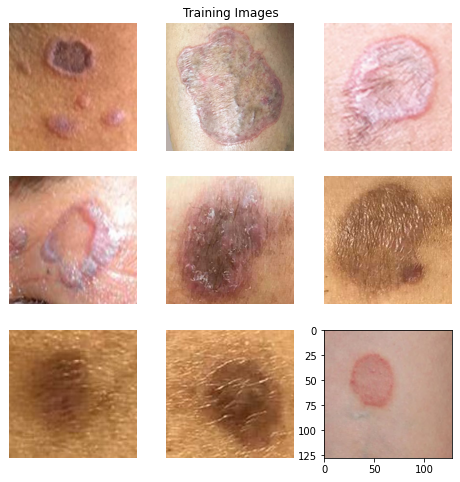

In [ ]:
# load the numpy vector containing image representations
imgs = np.load('kaggle_images_32x32.npz')
 
# pls ignore the poor quality of the images as we are working with 32x32 sized images.
plot_images(imgs['arr_0'], 3)

In [ ]:
class LP(Dataset):
 
    def __init__(self, npz_imgs):
        """
        Args:
            npz_imgs (string): npz file with all the images (created in gan.ipynb)
        """
        self.imgs = npz_imgs
 
    def __len__(self):
        return len(self.imgs)
 
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
 
        image = self.imgs[idx]
 
        return image

In [ ]:
# Preparing dataloader for training
 
transpose_imgs = np.transpose( # imp step to convert image size from (7312, 32,32,3) to (7312, 3,32,32)
    np.float32(imgs['arr_0']), # imp step to convert double -&gt; float (by default numpy input uses double as data type)
    (0, 3,1,2) # tuple to describe how to rearrange the dimensions
    ) 
 
dset = LP(transpose_imgs) # passing the npz variable to the constructor class
batch_size = 32
shuffle = True
 
dataloader = DataLoader(dataset = dset, batch_size = batch_size, shuffle = shuffle)

In [ ]:
class Generator(Module):
    def __init__(self):
 
        # calling constructor of parent class
        super().__init__()
 
        self.gen = Sequential(
          ConvTranspose2d(in_channels = 100, out_channels = 512 , kernel_size = 4, stride = 1, padding = 0, bias = False),
          # the output from the above will be b_size ,512, 4,4
          BatchNorm2d(num_features = 512), # From an input of size (b_size, C, H, W), pick num_features = C
          ReLU(inplace = True),
 
          ConvTranspose2d(in_channels = 512, out_channels = 256 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,256, 8,8
          BatchNorm2d(num_features = 256),
          ReLU(inplace = True),
 
          ConvTranspose2d(in_channels = 256, out_channels = 128 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,128, 16,16
          BatchNorm2d(num_features = 128),
          ReLU(inplace = True),
 
          ConvTranspose2d(in_channels = 128, out_channels = 3 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,3, 32,32
          Tanh()
         
        )
 
    def forward(self, input):
        return self.gen(input)

In [ ]:
# Defining the Discriminator class
 
class Discriminator(Module):
    def __init__(self):
 
        super().__init__()
        self.dis = Sequential(
 
            # input is (3, 32, 32)
            Conv2d(in_channels = 3, out_channels = 32, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32, 16, 16
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(in_channels = 32, out_channels = 32*2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*2, 8, 8
            BatchNorm2d(32 * 2),
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(in_channels = 32*2, out_channels = 32*4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*4, 4, 4
            BatchNorm2d(32 * 4),
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(in_channels = 32*4, out_channels = 32*8, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 256, 2, 2
            # NOTE: spatial size of this layer is 2x2, hence in the final layer, the kernel size must be 2 instead (or smaller than) 4
            BatchNorm2d(32 * 8),
            LeakyReLU(0.2, inplace=True),
 
            Conv2d(in_channels = 32*8, out_channels = 1, kernel_size = 2, stride = 2, padding = 0, bias=False),
            # ouput from above layer is b_size, 1, 1, 1
            Sigmoid()
        )
     
    def forward(self, input):
        return self.dis(input)

In [ ]:
netG = Generator().to(device)
netD = Discriminator().to(device)

In [ ]:
def init_weights(m):
    if type(m) == ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
# initializing the weights
netD.apply(init_weights)
netG.apply(init_weights)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

In [ ]:
# Setting up otimizers for both Generator and Discriminator
 
opt_D = optim.Adam(netD.parameters(), lr = 0.0002, betas= (0.5, 0.999))
opt_G = optim.Adam(netG.parameters(), lr = 0.0002, betas= (0.5, 0.999))

In [ ]:
# Setting up the loss function - BCELoss (to check how far the predicted value is from real value)
 
loss = BCELoss()

In [ ]:
# TRAINING GANS
epochs = 100
 
# going over the entire dataset 10 times
for e in range(epochs):
     
    # pick each batch b of input images: shape of each batch is (32, 3, 32, 32)
    for i, b in enumerate(dataloader):
 
        ##########################
        ## Update Discriminator ##
        ##########################
 
        # Loss on real images
         
        # clear the gradient
        opt_D.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = netD(b.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()
 
        # Loss on fake images
 
        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b), 100, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_img = netG(noise) 
 
        # compute D model output on fake images
        yhat = netD(fake_img.detach()).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_fake = loss(yhat, target)
        # calculate gradients
        loss_fake.backward()
 
        # total error on D
        loss_disc = loss_real + loss_fake
 
        # Update weights of D
        opt_D.step()
 
        ##########################
        #### Update Generator ####
        ##########################
 
        # clear gradient
        opt_G.zero_grad()
        # pass fake image through D
        yhat = netD(fake_img).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss(yhat, target)
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        opt_G.step()
 
 
        ####################################
        #### Plot some Generator images ####
        ####################################
 
        # during every epoch, print images at every 10th iteration.
        if i% 10 == 0:
            # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting 
            img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
            plot_images(img_plot)
            print("********************")
            print(" Epoch %d and iteration %d " % (e, i))

ValueError: ignored

In [ ]:
#.cuda

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/70], loss_g: 3.1505, loss_d: 0.1714, real_score: 0.9615, fake_score: 0.1178
Saving generated-images-0051.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [2/70], loss_g: 3.5589, loss_d: 0.1227, real_score: 0.9483, fake_score: 0.0636
Saving generated-images-0052.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [3/70], loss_g: 3.6988, loss_d: 0.0806, real_score: 0.9662, fake_score: 0.0438
Saving generated-images-0053.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [4/70], loss_g: 3.7222, loss_d: 0.1160, real_score: 0.9271, fake_score: 0.0364
Saving generated-images-0054.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [5/70], loss_g: 3.4847, loss_d: 0.0631, real_score: 0.9824, fake_score: 0.0438
Saving generated-images-0055.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [6/70], loss_g: 3.5795, loss_d: 0.0667, real_score: 0.9758, fake_score: 0.0406
Saving generated-images-0056.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [7/70], loss_g: 3.4896, loss_d: 0.0753, real_score: 0.9728, fake_score: 0.0454
Saving generated-images-0057.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [8/70], loss_g: 3.7769, loss_d: 0.0907, real_score: 0.9447, fake_score: 0.0313
Saving generated-images-0058.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [9/70], loss_g: 3.6506, loss_d: 0.0737, real_score: 0.9615, fake_score: 0.0331
Saving generated-images-0059.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [10/70], loss_g: 3.9231, loss_d: 0.0884, real_score: 0.9528, fake_score: 0.0374
Saving generated-images-0060.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [11/70], loss_g: 3.9225, loss_d: 0.0626, real_score: 0.9720, fake_score: 0.0332
Saving generated-images-0061.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [12/70], loss_g: 3.7965, loss_d: 0.0867, real_score: 0.9496, fake_score: 0.0335
Saving generated-images-0062.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [13/70], loss_g: 3.9524, loss_d: 0.0811, real_score: 0.9588, fake_score: 0.0373
Saving generated-images-0063.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [14/70], loss_g: 3.7592, loss_d: 0.0777, real_score: 0.9567, fake_score: 0.0318
Saving generated-images-0064.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [15/70], loss_g: 4.0631, loss_d: 0.0593, real_score: 0.9629, fake_score: 0.0206
Saving generated-images-0065.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [16/70], loss_g: 3.5536, loss_d: 0.0649, real_score: 0.9674, fake_score: 0.0304
Saving generated-images-0066.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [17/70], loss_g: 3.9473, loss_d: 0.0529, real_score: 0.9757, fake_score: 0.0276
Saving generated-images-0067.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [18/70], loss_g: 3.9257, loss_d: 0.0703, real_score: 0.9587, fake_score: 0.0270
Saving generated-images-0068.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [19/70], loss_g: 3.8669, loss_d: 0.0740, real_score: 0.9710, fake_score: 0.0429
Saving generated-images-0069.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [20/70], loss_g: 4.1744, loss_d: 0.0597, real_score: 0.9614, fake_score: 0.0194
Saving generated-images-0070.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [21/70], loss_g: 3.6414, loss_d: 0.0633, real_score: 0.9596, fake_score: 0.0210
Saving generated-images-0071.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [22/70], loss_g: 3.8123, loss_d: 0.0619, real_score: 0.9693, fake_score: 0.0296
Saving generated-images-0072.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [23/70], loss_g: 3.9704, loss_d: 0.0513, real_score: 0.9711, fake_score: 0.0212
Saving generated-images-0073.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [24/70], loss_g: 4.0915, loss_d: 0.1138, real_score: 0.9226, fake_score: 0.0251
Saving generated-images-0074.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [25/70], loss_g: 3.7313, loss_d: 0.0713, real_score: 0.9501, fake_score: 0.0187
Saving generated-images-0075.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [26/70], loss_g: 4.2766, loss_d: 0.0762, real_score: 0.9501, fake_score: 0.0236
Saving generated-images-0076.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [27/70], loss_g: 4.7188, loss_d: 0.0569, real_score: 0.9804, fake_score: 0.0359
Saving generated-images-0077.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [28/70], loss_g: 3.6535, loss_d: 0.1234, real_score: 0.9005, fake_score: 0.0159
Saving generated-images-0078.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [29/70], loss_g: 4.1202, loss_d: 0.0735, real_score: 0.9742, fake_score: 0.0458
Saving generated-images-0079.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [30/70], loss_g: 4.4401, loss_d: 0.0651, real_score: 0.9605, fake_score: 0.0238
Saving generated-images-0080.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [31/70], loss_g: 4.3407, loss_d: 0.0912, real_score: 0.9304, fake_score: 0.0157
Saving generated-images-0081.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [32/70], loss_g: 4.2368, loss_d: 0.0596, real_score: 0.9689, fake_score: 0.0270
Saving generated-images-0082.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [33/70], loss_g: 4.6829, loss_d: 0.0414, real_score: 0.9784, fake_score: 0.0192
Saving generated-images-0083.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [34/70], loss_g: 4.2569, loss_d: 0.0343, real_score: 0.9780, fake_score: 0.0117
Saving generated-images-0084.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [35/70], loss_g: 3.9751, loss_d: 0.0641, real_score: 0.9784, fake_score: 0.0409
Saving generated-images-0085.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [36/70], loss_g: 4.7309, loss_d: 0.0388, real_score: 0.9750, fake_score: 0.0132
Saving generated-images-0086.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [37/70], loss_g: 4.5347, loss_d: 0.0437, real_score: 0.9807, fake_score: 0.0236
Saving generated-images-0087.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [38/70], loss_g: 4.7764, loss_d: 0.0516, real_score: 0.9727, fake_score: 0.0233
Saving generated-images-0088.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [39/70], loss_g: 4.3215, loss_d: 0.0749, real_score: 0.9440, fake_score: 0.0160
Saving generated-images-0089.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [40/70], loss_g: 4.2909, loss_d: 0.0499, real_score: 0.9721, fake_score: 0.0211
Saving generated-images-0090.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [41/70], loss_g: 3.5892, loss_d: 0.0488, real_score: 0.9701, fake_score: 0.0178
Saving generated-images-0091.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [42/70], loss_g: 4.4162, loss_d: 0.0289, real_score: 0.9840, fake_score: 0.0126
Saving generated-images-0092.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [43/70], loss_g: 4.4092, loss_d: 0.0520, real_score: 0.9644, fake_score: 0.0152
Saving generated-images-0093.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [44/70], loss_g: 4.6619, loss_d: 0.0393, real_score: 0.9797, fake_score: 0.0184
Saving generated-images-0094.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [45/70], loss_g: 4.5788, loss_d: 0.0432, real_score: 0.9765, fake_score: 0.0189
Saving generated-images-0095.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [46/70], loss_g: 4.4425, loss_d: 0.0368, real_score: 0.9795, fake_score: 0.0158
Saving generated-images-0096.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [47/70], loss_g: 4.6933, loss_d: 0.0221, real_score: 0.9864, fake_score: 0.0083
Saving generated-images-0097.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [48/70], loss_g: 3.9743, loss_d: 0.0555, real_score: 0.9658, fake_score: 0.0198
Saving generated-images-0098.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [49/70], loss_g: 4.8202, loss_d: 0.0407, real_score: 0.9834, fake_score: 0.0234
Saving generated-images-0099.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [50/70], loss_g: 4.6612, loss_d: 0.0277, real_score: 0.9874, fake_score: 0.0148
Saving generated-images-0100.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [51/70], loss_g: 5.1167, loss_d: 0.0297, real_score: 0.9828, fake_score: 0.0121
Saving generated-images-0101.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [52/70], loss_g: 4.3179, loss_d: 0.0659, real_score: 0.9518, fake_score: 0.0154
Saving generated-images-0102.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [53/70], loss_g: 4.1958, loss_d: 0.0413, real_score: 0.9795, fake_score: 0.0201
Saving generated-images-0103.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [54/70], loss_g: 4.8629, loss_d: 0.0457, real_score: 0.9715, fake_score: 0.0162
Saving generated-images-0104.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [55/70], loss_g: 4.9771, loss_d: 0.0485, real_score: 0.9703, fake_score: 0.0177
Saving generated-images-0105.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [56/70], loss_g: 4.6695, loss_d: 0.0285, real_score: 0.9898, fake_score: 0.0180
Saving generated-images-0106.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [57/70], loss_g: 5.1810, loss_d: 0.0306, real_score: 0.9854, fake_score: 0.0156
Saving generated-images-0107.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [58/70], loss_g: 4.1404, loss_d: 0.0391, real_score: 0.9737, fake_score: 0.0120
Saving generated-images-0108.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [59/70], loss_g: 4.5545, loss_d: 0.0365, real_score: 0.9785, fake_score: 0.0144
Saving generated-images-0109.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [60/70], loss_g: 4.7654, loss_d: 0.0304, real_score: 0.9810, fake_score: 0.0110
Saving generated-images-0110.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [61/70], loss_g: 4.2014, loss_d: 0.0270, real_score: 0.9843, fake_score: 0.0110
Saving generated-images-0111.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [62/70], loss_g: 4.4217, loss_d: 0.0284, real_score: 0.9864, fake_score: 0.0144
Saving generated-images-0112.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [63/70], loss_g: 4.8972, loss_d: 0.0295, real_score: 0.9878, fake_score: 0.0170
Saving generated-images-0113.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [64/70], loss_g: 4.1840, loss_d: 0.0636, real_score: 0.9583, fake_score: 0.0200
Saving generated-images-0114.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [65/70], loss_g: 4.6295, loss_d: 0.0407, real_score: 0.9784, fake_score: 0.0185
Saving generated-images-0115.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [66/70], loss_g: 5.5586, loss_d: 0.0346, real_score: 0.9854, fake_score: 0.0194
Saving generated-images-0116.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [67/70], loss_g: 4.3785, loss_d: 0.0600, real_score: 0.9487, fake_score: 0.0062
Saving generated-images-0117.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [68/70], loss_g: 4.4849, loss_d: 0.0514, real_score: 0.9629, fake_score: 0.0130
Saving generated-images-0118.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [69/70], loss_g: 4.4205, loss_d: 0.0792, real_score: 0.9405, fake_score: 0.0161
Saving generated-images-0119.png


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [70/70], loss_g: 4.9404, loss_d: 0.0353, real_score: 0.9874, fake_score: 0.0220
Saving generated-images-0120.png
